<a href="https://colab.research.google.com/github/sharan11/Intro-to-Deep-Learning-with-Pytorch-Exercise-Solutions/blob/master/Training_Neural_Networks_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 8505979.31it/s]                            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 130887.88it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


1654784it [00:00, 2121133.55it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


8192it [00:00, 49121.41it/s]            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


In [0]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)
print(images.shape)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

torch.Size([64, 784])
tensor(2.3149, grad_fn=<NllLossBackward>)


**Exercise:** Build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss. Note that for nn.LogSoftmax and F.log_softmax you'll need to set the dim keyword argument appropriately. dim=0 calculates softmax across the rows, so each column sums to 1, while dim=1 calculates across the columns so each row sums to 1. Think about what you want the output to be and choose dim appropriately.

In [14]:
## Solution
# TODO: Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim=1))

# TODO: Define the loss
criterion = nn.NLLLoss()

### Run this to check your work
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2990, grad_fn=<NllLossBackward>)


## AutoGrad

In [6]:
# Example

x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-1.6529,  0.4632],
        [-1.3790,  0.8256]], requires_grad=True)


In [7]:
y = x**2
print(y)

tensor([[2.7320, 0.2145],
        [1.9017, 0.6816]], grad_fn=<PowBackward0>)


In [8]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

In [9]:
z = y.mean()
print(z)

tensor(1.3825, grad_fn=<MeanBackward0>)


In [10]:
print(x.grad)

None


To calculate the gradients, you need to run the .backward method on a Variable, z for example. This will calculate the gradient for z with respect to x

In [11]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.8264,  0.2316],
        [-0.6895,  0.4128]])
tensor([[-0.8264,  0.2316],
        [-0.6895,  0.4128]], grad_fn=<DivBackward0>)


### Loss and Autograd together

In [0]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [16]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0022,  0.0022,  0.0022,  ...,  0.0022,  0.0022,  0.0022],
        [-0.0017, -0.0017, -0.0017,  ..., -0.0017, -0.0017, -0.0017],
        [-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011],
        ...,
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [ 0.0011,  0.0011,  0.0011,  ...,  0.0011,  0.0011,  0.0011],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


### Training the network!

In [0]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [18]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0138, -0.0302, -0.0155,  ...,  0.0002,  0.0012, -0.0131],
        [ 0.0250,  0.0184, -0.0347,  ...,  0.0013, -0.0111, -0.0197],
        [-0.0323,  0.0087,  0.0035,  ..., -0.0176, -0.0188, -0.0291],
        ...,
        [ 0.0009,  0.0034, -0.0327,  ..., -0.0185,  0.0080,  0.0190],
        [ 0.0350,  0.0220,  0.0028,  ...,  0.0156,  0.0060, -0.0048],
        [-0.0147,  0.0243,  0.0066,  ...,  0.0034,  0.0051,  0.0125]],
       requires_grad=True)
Gradient - tensor([[ 0.0061,  0.0061,  0.0061,  ...,  0.0061,  0.0061,  0.0061],
        [-0.0037, -0.0037, -0.0037,  ..., -0.0037, -0.0037, -0.0037],
        [-0.0027, -0.0027, -0.0027,  ..., -0.0027, -0.0027, -0.0027],
        ...,
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [19]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0138, -0.0302, -0.0155,  ...,  0.0001,  0.0011, -0.0132],
        [ 0.0250,  0.0185, -0.0347,  ...,  0.0014, -0.0111, -0.0197],
        [-0.0323,  0.0087,  0.0036,  ..., -0.0176, -0.0188, -0.0290],
        ...,
        [ 0.0009,  0.0034, -0.0327,  ..., -0.0185,  0.0080,  0.0190],
        [ 0.0350,  0.0220,  0.0028,  ...,  0.0156,  0.0060, -0.0048],
        [-0.0147,  0.0243,  0.0066,  ...,  0.0034,  0.0051,  0.0125]],
       requires_grad=True)


### Training for real

**Exercise**: Implement the training pass for our network. If you implemented it correctly, you should see the training loss drop with each epoch.

In [20]:
## Solution
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9976958523172814
Training loss: 0.9550237140930029
Training loss: 0.5515303273063733
Training loss: 0.44509589381373005
Training loss: 0.3962491429023651


In [22]:
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py

--2019-11-08 14:36:17--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2019-11-08 14:36:17 (67.2 MB/s) - ‘helper.py’ saved [2813/2813]



In [0]:
import matplotlib.pyplot as plt
import numpy as np
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

With the network trained, we can check out it's predictions.

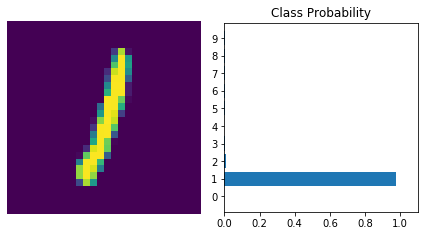

In [26]:
%matplotlib inline

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)

In [27]:
running_loss

371.6816960424185

In [28]:
len(trainloader)

938